# Supporting Information:Understanding Associative Polymer Self-Assembly with Shrinking Gate Fluorescence Correlation Spectroscopy
## Timothy J. Murdoch, Baptiste Quienne, Julien Pinaud, Sylvain Caillol and Ignacio Martín-Fabiani

This Jupyter notebook outlines the processing of fluorescence lifetime spectroscopy data collected via time-correlated single photon counting on a PicoQuant MT200 confocal microscope. It describes the data importing, instrument response function filtering and iterative reconvolution fitting combined with Markov chain Monte Carlo (MCMC) sampling to determine uncertainties. 

## Package Imports
Aside from common Python libraries, we have modified code from the following repositories:

[readPTU_FLIM](https://github.com/RNA-FRETools/Lifefit) - added functionality to import data from point measurements

[Lifefit](https://github.com/RNA-FRETools/Lifefit) - utilised the convolution, irf_scaleshift, and exp_decay functions but used a modified iterative reconvolution to allow use of lmfit package as well as incorporating the maximum likelihood estimator to weight fits

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy.optimize
import copy
import pickle

In [2]:
from lmfit import Model, Parameters
from lmfit import create_params, fit_report, minimize, Minimizer
import corner

In [4]:
import os

In [4]:
from Scripts.TCSPC import *

c:\Users\timot\OneDrive - Loughborough University\Documents\UKRIFLF Nacho\Experiments\FLIM\Python Code\sgFCS_PTU\Scripts\TCSPC.py:776: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False) #I need to double check this
c:\Users\timot\OneDrive - Loughborough University\Documents\UKRIFLF Nacho\Experiments\FLIM\Python Code\sgFCS_PTU\Scripts\TCSPC.py:852: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-

## Identify Pulse in IRF
The instrument response function (IRF) reflects how a component with an infinitely short lifetime is seen by the instrument. It has contributions from the laser, detector, optics, and electronics. While the measured IRF can be used directly, noise towards from over the complete time correlated single photon counting (TCSPC) window can introduce noise fluctuations at later times in the reconvolution fitting. Therefore we use a time gate that excludes the background from the IRF when processing the data

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



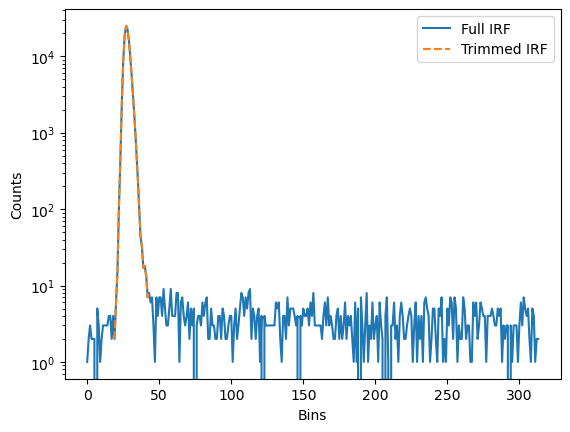

In [7]:
IRF_path = 'Raw_Data/IRF_quick1.ptu'
IRF_decay, IRF_tau, IRF_timestep = load_store(IRF_path,norm = False, back = False)

IRF_min = 19
IRF_max = 44
IRF_trim = IRF_decay.copy()
IRF_trim = IRF_trim[IRF_min:IRF_max,1]

plt.semilogy(IRF_decay[:,1],label='Full IRF')
plt.plot(np.array(range(len(IRF_trim)))+IRF_min,IRF_trim,'--',label='Trimmed IRF')
plt.ylabel('Counts')
plt.xlabel('Bins')
plt.legend()

## Single File Fitting
### Data import
Data are imported using the loader function. This function takes a dataframe containing paths to experimental files, as well instructions on what regions of the data and IRF to use. The function then outputs data, IRF, and error arrays used for fitting and plotting 

In [10]:
file = 'filenames_Conc_full.xlsx'
df = pd.read_excel(file)
df

,paths,pickle_name
0,../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_...,0_01wtHC12_12nMsCy3_230607
1,../../2023/230608_clean_ibidi_ctd.sptw/HC12_0_...,0_1wtHC12_12nMsCy3_230608
2,../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_...,0_16wtHC12_12nMsCy3_230607
3,../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_...,0_25wtHC12_12nMsCy3_230607
4,../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_...,0_4wtHC12_12nMsCy3_230607
5,../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_...,0_63wtHC12_12nMsCy3_230607
6,../../2023/230607_clean_ibidi_fcs.sptw/HC12_1w...,1wtHC12_12nMsCy3_230607
7,../../2023/230420_ibidi_FCS.sptw/HC12_2_1.ptu,2wtHC12_12nMsCy3_230420
8,../../2023/230420_ibidi_FCS.sptw/HC12_5_1.ptu,5wtHC12_12nMsCy3_230420


In [11]:
file_num = 6
IRF_path = None
IRF_min = 19
IRF_max = 44
ns_channel,data, IRF, eps = loader(df,num=file_num,IRF_path=IRF_path,IRF_min=IRF_min,IRF_max=IRF_max,low_cut=5,high_cut=5,sub=True,sub_low=2e7,sub_high=2.05e7)

c:\Users\timot\OneDrive - Loughborough University\Documents\UKRIFLF Nacho\Experiments\FLIM\Python Code\sgFCS_PTU\Scripts\TCSPC.py:774: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  
c:\Users\timot\OneDrive - Loughborough University\Documents\UKRIFLF Nacho\Experiments\FLIM\Python Code\sgFCS_PTU\Scripts\TCSPC.py:850: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



AttributeError: 'PTUreader' object has no attribute 'get_tcspc_decay_sub'

### Running the fits
The intensity decay $I(t)$ is fit by iterative reconvolution of the IRF with the sum of $n$ exponential decays with amplitude $\alpha$ and lifetime $\tau$:
$$ I(t) = IRF \ast \sum_i \alpha_i e^{-t/\tau_i} $$

During fitting we minimize the negative log-likelihood function by adjusting a vector of parameters $\theta$:

$$ -\ln L(\theta) = \sum_j (c_{j,\text{exp}} \ln(c_{j,\text{exp}}/c_{j,\text{model}}(\theta)) - (c_\text{exp} - c_{j,\text{model}}(\theta)) $$
where $c_{j,\text{exp}}$ and $c_{j,\text{model}}(\theta)$ are the experimental and model counts for channel $j$. This is equivalent to maximising the log-likelihood (Eur Biophys J,1991,20,247)

To run the fits we generate a dictionary of parameters with the paramser function used to initialise a Nelder-mead optimisation. Aside from $\alpha$  and $\tau$, we also optimise the background counts and shift in IRF are allowed to vary. The result of this optimisation is used to initialise subsequent Markov chain Monte Carlo (MCMC) to determine parameter uncertainties. 



In [77]:
vals_dict_3 = {'tau_1':0.1,'tau_2':0.3,'tau_3':1,'bck':40,'shift':-5} #Optional 
#lims_dict_3 = {'tau_1':[0.05,0.2]} can also supplied to paramser to change the default limits
mod3,params = paramser(3,vals_dict=vals_dict_3)
t_ns = data[:,0]

#NB if one wanted to use a least squared with Poissonian weights you could use result = mod3.fit(data[:,1],t_ns = t_ns,IRF = IRF, ns_channel=ns_channel, params=params,nan_policy='omit',weights=1/eps)
out = minimize(recon3_MLE, params, args=(IRF,t_ns,ns_channel,eps,),method='Nelder')

fitter_3 = Minimizer(recon3_MLE, params = out.params ,fcn_args=(IRF,t_ns,ns_channel,eps,))
fitter_3.emcee(steps=10000, burn=8000, thin=200, is_weighted=True,
                 progress=True,float_behavior='chi2')

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:43<00:00, 24.80it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [566.72843415 528.95228529 607.51985781 607.4636647  537.71414235
 565.67152853 230.57455141 331.04118722]


### Looking at the results

In [82]:
#Fitting results for Nelder-mead fit
out

In [81]:
#Fitting results for MCMC sampling
fitter_3.result

We can visualise the goodness of fit by plotting the experimental data and IRF, and compare them to the calculated model. We also plot the residual contribution of each channel to $-L$. A good fit will have randomly distributed residuals.

For comparison with more commonly used reduced $\chi^2$, we use Neyman's $\chi^2$ which uses the experimentally measured values as an estimate of variance. NB for stability we set $c_{j,\text{exp}} = 0$ to 1.
$\chi^2_{N2} = \frac{(c_{j,\text{model}} - c_{j,\text{exp}})^2}{c_{j,\text{exp}}}$ 


-log-likelihood 184.86
Poissonian Reduced Chi^2 1.26 


Text(0.5, 0, 'Time (ns)')

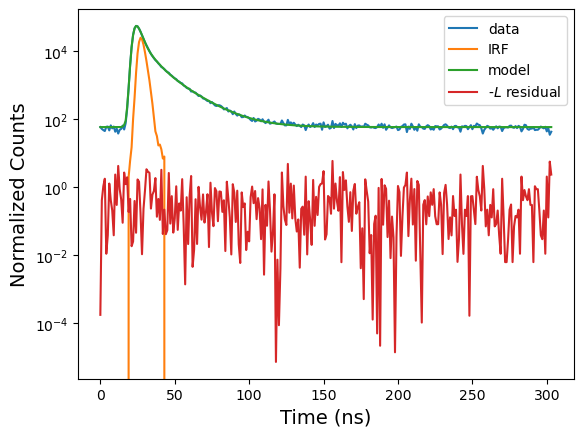

In [84]:
#Calculating the best fit curve
res = fitter_3.result
model = mod3.eval(params=res.params,IRF=IRF,t_ns=t_ns,ns_channel=ns_channel)

print(f'-log-likelihood {compute_sum(eps, model):.2f}')
print(f'Poissonian Reduced Chi^2 {red_chi_N1(eps,model):.2f} ' ) 
plt.semilogy(data[:,1],label='data')
plt.semilogy(IRF[:,1],label='IRF')
plt.semilogy(model,label='model')
plt.plot(eps*np.log(eps/model) - (eps-model),label='-$L$ residual')
plt.legend()
plt.ylabel('Normalized Counts',fontsize=14)
plt.xlabel('Time (ns)',fontsize=14)

We can check that we have sampled long enough by plotting the time series of parameters in the chain. We can see that the walkers are initialised around the best fit parameters from the Nelder-Mead optimisation. Initially there is significant change in the parameter values as the walkers explore the parameter space and 'burn-in'.  After 2000 steps or so the parameters have stabilised. To make sure this is the case for most fits, we discard the first 8000 steps for the final results. 

Text(0.5, 0, 'steps/10')

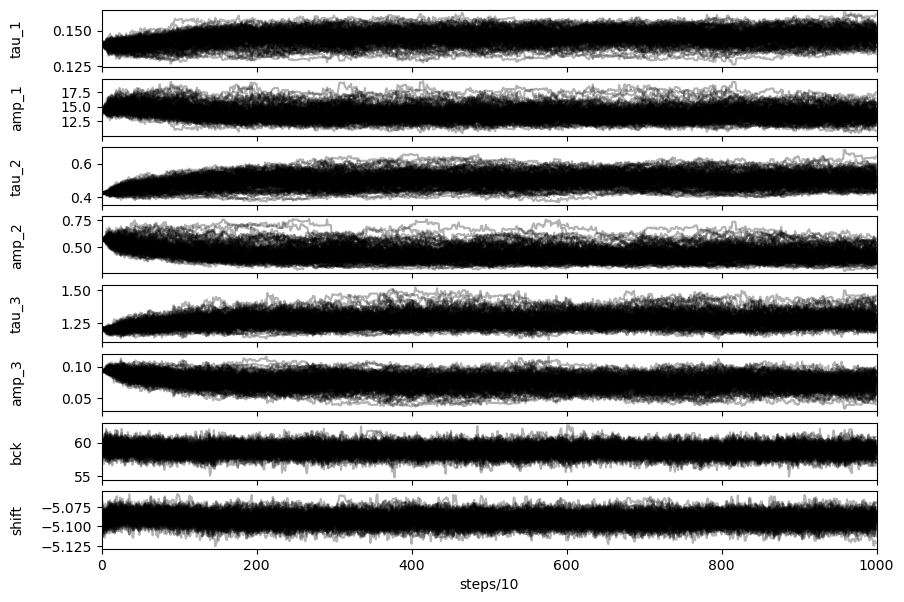

In [104]:
samples = fitter_3.sampler.get_chain(thin=10)
ndim = samples.shape[2]
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = res.var_names
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
ax.set_xlabel('steps/10')

We can visualise the spread in the model by sampling random sets of params from the MCMC sampling and plotting them with high transparency.

Text(0.5, 0, 'Time (ns)')

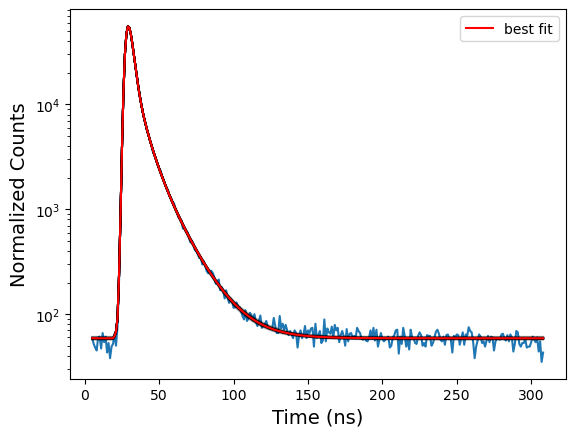

In [87]:
res = fitter_3.result
plt.semilogy(data[:,0],data[:,1])

for pars in pgen(res.params,
                 res.flatchain,
                 idx=np.random.choice(len(res.flatchain), size=100, replace=False)):
    plt.semilogy(data[:,0],mod3.eval(params=pars,IRF=IRF,t_ns=t_ns,ns_channel=ns_channel), color="k", alpha=0.05)
plt.plot(data[:,0],mod3.eval(params=res.params,IRF=IRF,t_ns=t_ns,ns_channel=ns_channel), color='r',label='best fit')
plt.legend()
plt.ylabel('Normalized Counts',fontsize=14)
plt.xlabel('Time (ns)',fontsize=14)


We can use a corner plot to show the one and two dimensional projections of the posterior probality distributions. This allows covariances between parameters to be easily visualised.

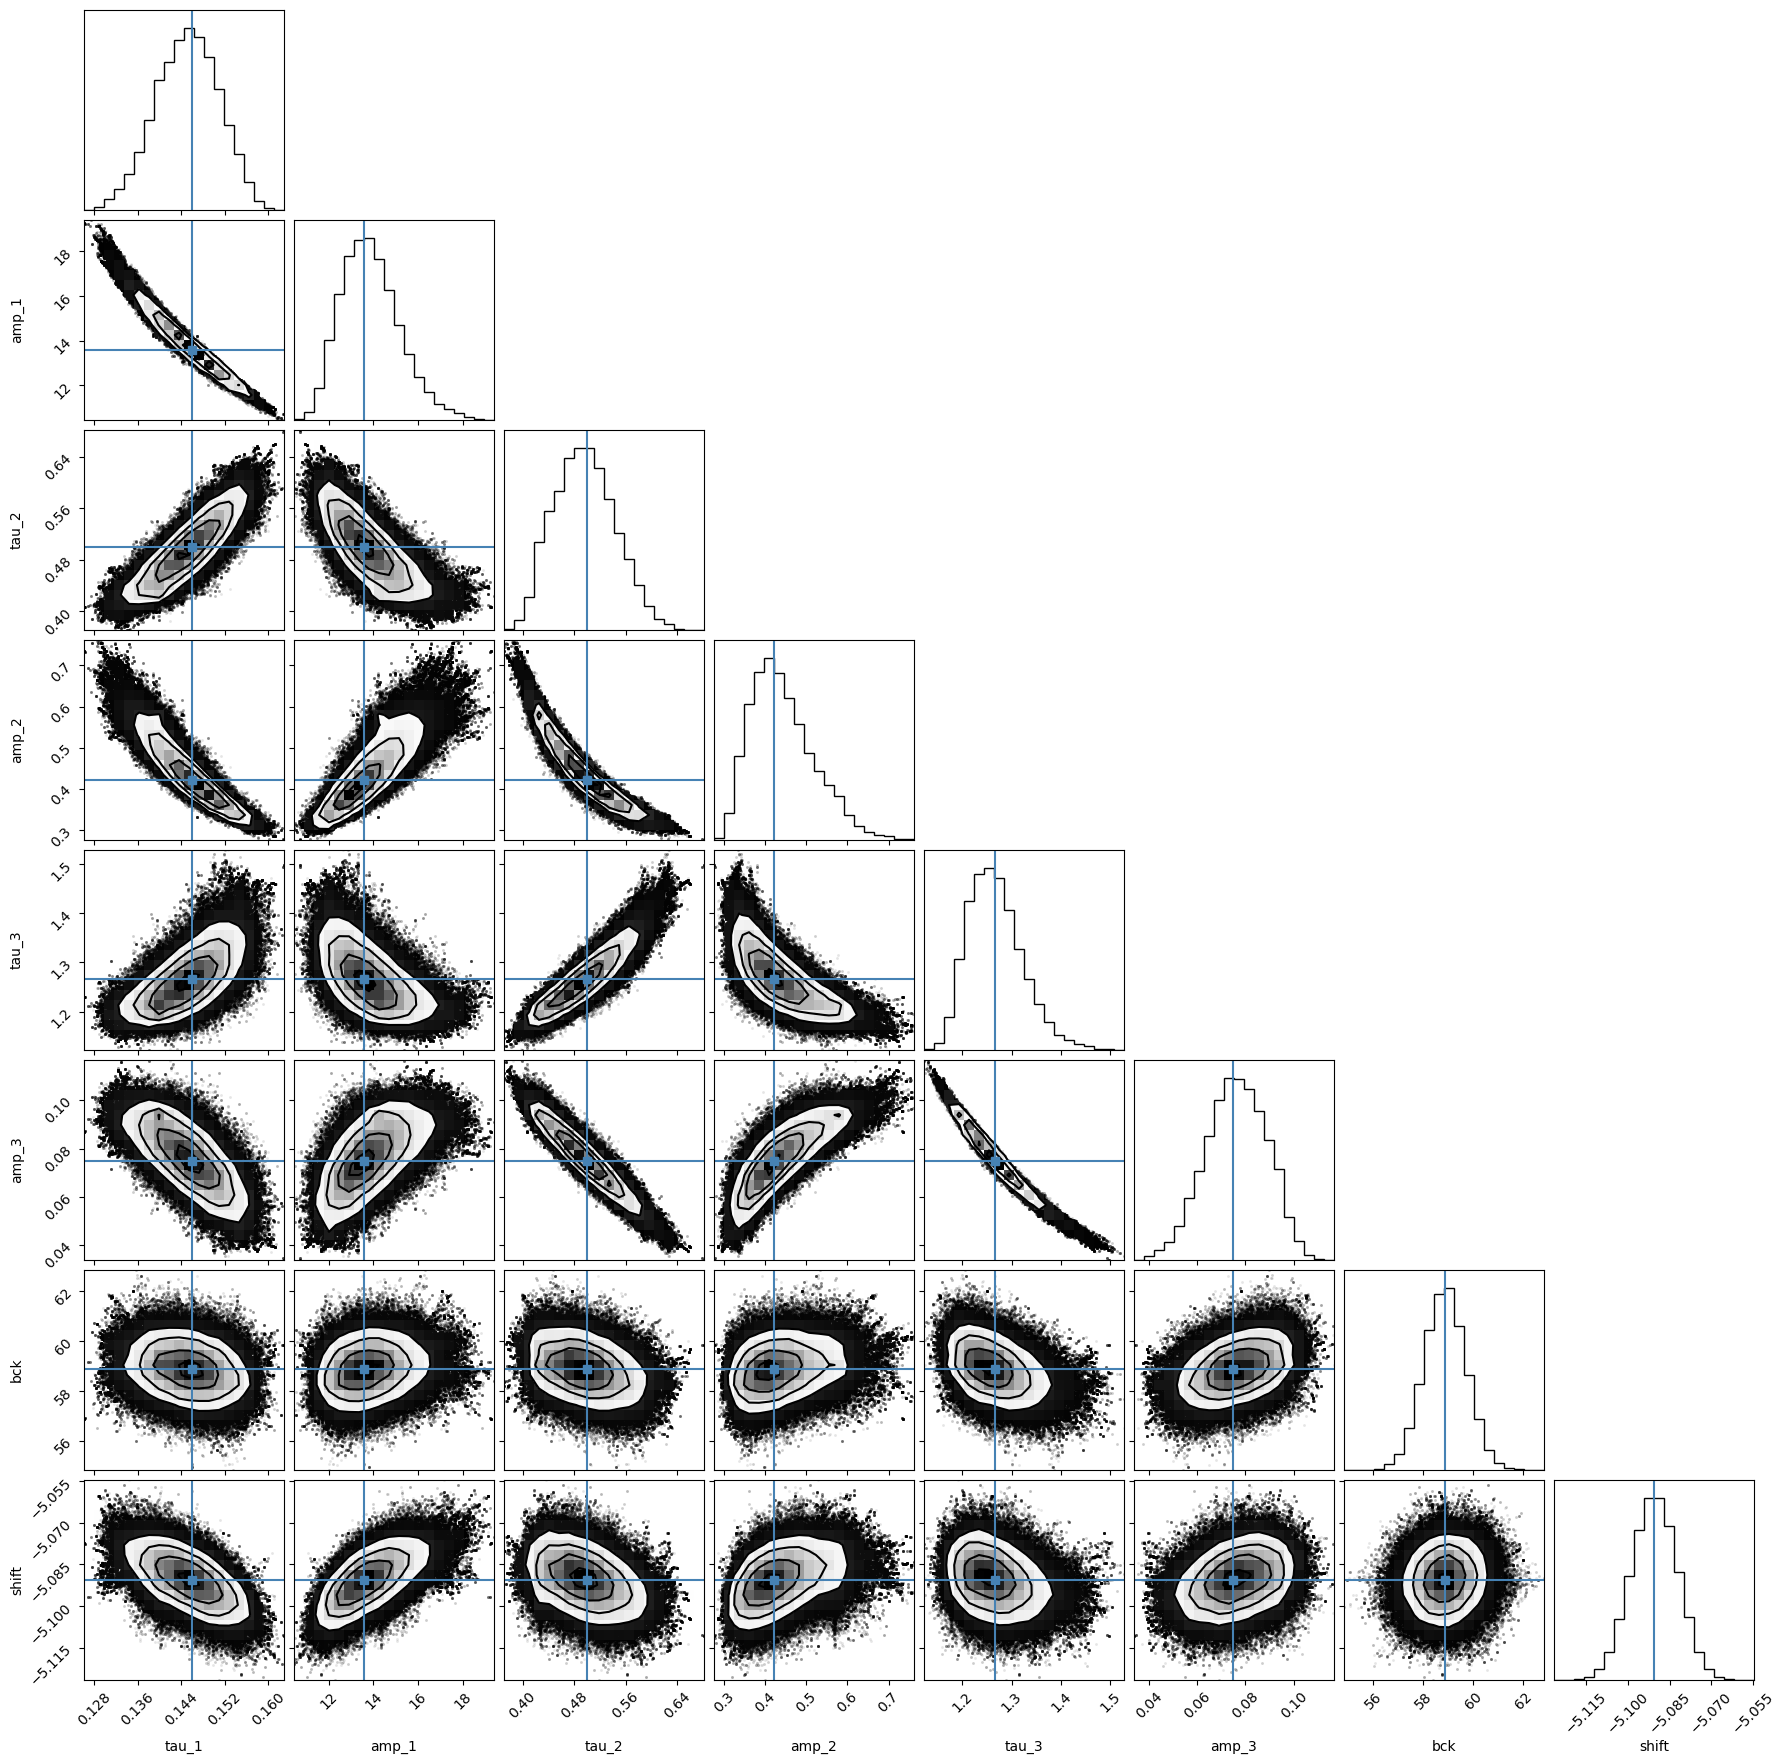

In [97]:
emcee_corner = corner.corner(fitter_3.sampler.flatchain, labels=res.var_names,
                             truths=[fitter_3.values[free] for free in res.var_names])

## Batch Fitting
Batch fitting uses an excel file that contains paths and sample descriptions. It then applies the single fitting approach (i.e. initial optimisation followed by MCMC sampling) to each ptu file. The batcher_MLE function returns a dataframe (res3) containing fitted parameters, standard deviations, $-L$, and reduced Chi2. This dataframe is also exported to excel. It also returns mod3, which is a list containing of the fitter_3 objects, and dat3, which contains the raw data and IRF. 

In [192]:
file = 'filenames_Conc_full.xlsx'
df = pd.read_excel(file)
IRF_path = None
IRF_min = 19
IRF_max = 44
res3, mod3, dat3 = batcher_MLE(df,n_tau=3,steps=10000,burn=8000,IRF_path=IRF_path,IRF_min=IRF_min,IRF_max=IRF_max,shift=-5,sub=True)
res3.to_excel('tau3_supp.xlsx')

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:17<00:00, 26.47it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [1285.95694554 1125.0652167  1179.79081812 1290.71184567  695.41515326
  849.05632357  435.62721541  882.15781037]
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:18<00:00, 31.43it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [1056.8231592  1046.99357827  815.7890081   847.24241992  588.57720697
  609.18180557  377.79469604  709.19285373]
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:24<00:00, 30.78it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [700.08287528 550.145688   770.34064533 754.03876339 677.53450417
 714.48171828 307.98789553 368.10235198]
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:15<00:00, 31.71it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [760.11402977 690.51446781 784.45759405 777.15658589 612.78759497
 646.3080525  232.82763527 343.78776639]
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:28<00:00, 25.76it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [1036.11487804  945.33453104 1060.06790528 1074.65947392  912.7964546
  975.39746653  357.95650902  451.19018997]
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:23<00:00, 30.87it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [527.22573464 489.67592682 556.365213   551.89190392 469.17964025
 496.48960496 220.97627889 292.55041459]
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:34<00:00, 29.90it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [595.35668892 569.39639208 554.89947473 610.66051754 397.5891952
 376.68767289 195.25963764 330.3365881 ]
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:53<00:00, 24.21it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [1133.46551139 1061.66084977 1172.73852647  917.96481175 1156.9793193
 1127.9786292  1015.73537031  755.95491813]
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:21<00:00, 31.11it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [1028.12745043  836.99845414 1108.53822221  876.87961652 1066.9453672
 1100.5819347   667.00489547  455.56405522]


We pickle the mod3 and dat3 objects so that we can load them without repeating the batch fitting

In [193]:
with open("Processed_Data/mod3_MLE.bin", "wb") as f: 
    pickle.dump(mod3, f)
with open("Processed_Data/dat3_MLE.bin", "wb") as f: 
    pickle.dump(dat3, f)

In [18]:
with open("Processed_Data/mod3_MLE.bin", "rb") as f: 
    mod3 = pickle.load(f)
with open("Processed_Data/dat3_MLE.bin", "rb") as f: 
    dat3 = pickle.load(f)

The dat3 and mod3 objects can be used to visualise the fits for any condition

-log-likelihood 175.65
Poissonian Reduced Chi^2 1.19 


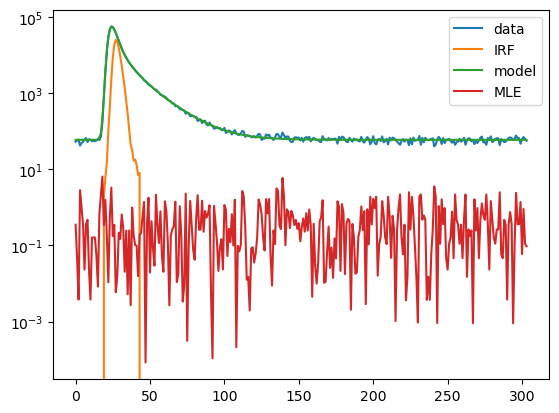

In [22]:
ind = 6
data = dat3.exp[ind]
IRF = dat3.IRF[ind]
res = mod3[ind]
t_ns = data[:,0]
ns_channel = dat3.timestep[ind]
data_plot = data[:,1]
mod,_ = paramser(3)
eps = data_plot.copy()
eps[eps<1]=1
model = mod.eval(params=res.params,IRF=IRF,t_ns=t_ns,ns_channel=ns_channel) 
print(f'-log-likelihood {compute_sum(eps, model):.2f}')
print(f'Poissonian Reduced Chi^2 {red_chi_N1(eps,model):.2f} ' ) 
plt.semilogy(data_plot,label='data')
plt.semilogy(IRF[:,1],label='IRF')
plt.semilogy(model,label='model')
plt.plot(data_plot*np.log(data_plot/model) - (data_plot-model),label='MLE')

plt.legend()
# plt.ylim(1,)

### Combined Results

In [24]:
with open("Processed_Data/mod3_MLE.bin", "rb") as f: 
    mod3 = pickle.load(f)
with open("Processed_Data/dat3_MLE.bin", "rb") as f: 
    dat3 = pickle.load(f)
with open("Processed_Data/sCy3_12nM_model.bin", "rb") as f: 
    mod_sCy3 = pickle.load(f)
with open("Processed_Data/sCy3_12nM_data.bin", "rb") as f: 
    dat_sCy3, ns_channel_sCy3, IRF_sCy3 = pickle.load(f)

In [25]:
file = '../FCS Development/filenames_ibidi_Conc_full.xlsx'
df = pd.read_excel(file)
concs = [0.01,0.1,0.16,0.25,0.4,0.63,1,2,5]
conc_str = [f"{number:.{2}f}" for number in concs]
conc_str

['0.01', '0.10', '0.16', '0.25', '0.40', '0.63', '1.00', '2.00', '5.00']

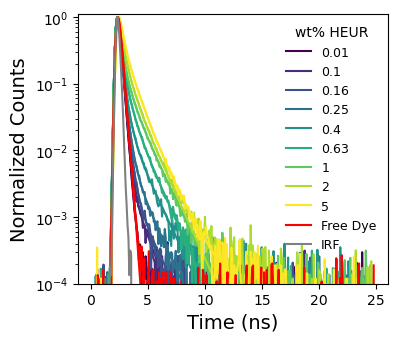

In [26]:
colors = [plt.cm.viridis(i) for i in np.linspace(0,1,9)]
mod,_ = paramser(3)
# concs = [0.01,0.1,0.16,0.25,0.4,0.63,1,2,5]
# conc_str = [f"{number:.{2}f}" for number in concs]
conc_str = ['0.01','0.1','0.16','0.25','0.4','0.63','1','2','5']

fig, ax = plt.subplots(figsize=(4,3.5))


for ind in range(9):
    ns_channel = dat3.timestep[ind]
    data = dat3.exp[ind]
    IRF = dat3.IRF[ind]
    res = mod3[ind]
    t_ns = data[:,0]
    data_plot = data[:,1] - res.params['bck'].value
    model = mod.eval(params=res.params,IRF=IRF,t_ns=t_ns,ns_channel=ns_channel)  - res.params['bck'].value
    ax.semilogy(t_ns*ns_channel,data_plot/np.max(data_plot),label=conc_str[ind],color=colors[ind])
    # plt.semilogy(IRF[:,1],label='IRF')
    # plt.semilogy(eps,label='error')
    ax.semilogy(t_ns*ns_channel,model/np.max(model),color=colors[ind])

res = mod_sCy3.result
mod,_ = paramser(1)
dat_sCy3_plot = dat_sCy3[:,1] - res.params['bck'].value
model = mod.eval(params=res.params,IRF=IRF_sCy3,t_ns=dat_sCy3[:,0],ns_channel=ns_channel)- res.params['bck'].value
ax.semilogy(dat_sCy3[:,0]*ns_channel_sCy3+0.13,dat_sCy3_plot/np.max(dat_sCy3_plot),color='red',label='Free Dye')
ax.semilogy(dat_sCy3[:,0]*ns_channel+0.13,model/np.max(model),color='red',)
ax.semilogy(IRF[:,0]*ns_channel+0.1,IRF[:,1]/np.max(IRF),color='grey',label='IRF')

ax.legend(title='wt% HEUR',frameon=False,fontsize=9)
ax.set_ylim(1e-4,1.1)
# plt.xlim(0,5)
ax.set_ylabel('Normalized Counts',fontsize=14)
ax.set_xlabel('Time (ns)',fontsize=14)
plt.savefig('12.5 nM TCSPC.png',bbox_inches='tight',dpi=300)